# Context

This Dataset taken from [Kaggle](https://www.kaggle.com/ntnu-testimon/banksim1)

# Original paper

Lopez-Rojas, Edgar Alonso ; Axelsson, Stefan
Banksim: A bank payments simulator for fraud detection research Inproceedings
26th European Modeling and Simulation Symposium, EMSS 2014, Bordeaux, France, pp. 144–152, Dime University of Genoa, 2014, ISBN: 9788897999324.
https://www.researchgate.net/publication/265736405_BankSim_A_Bank_Payment_Simulation_for_Fraud_Detection_Research

# Attributes Information

    Step: This feature represents the day from the start of simulation. 
    It has 180 steps so simulation ran for virtually 6 months.
    Customer: This feature represents the customer id
    Age: Categorized age
     0: <= 18,
     1: 19-25,
     2: 26-35,
     3: 36-45,
     4: 46-55,
     5: 56-65,
     6: > 65
     U: Unknown
    zipCodeOrigin: The zip code of origin/source.
    Merchant: The merchant's id
    zipMerchant: The merchant's zip code
    Gender: Gender for customer
        E : Enterprise,
        F: Female,
        M: Male,
        U: Unknown
    Category: Category of the purchase.
    Amount: Amount of the purchase
    Fraud: Target variable which shows if the transaction fraudulent(1) or benign(0)


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import ppscore as pps
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, average_precision_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Real, Integer
from jcopml.plot import plot_pr_curve
from xgboost import XGBClassifier

In [4]:
sns.set_style('whitegrid')

In [5]:
df = pd.read_csv('bs140513_032310.csv')
df.shape

(594643, 10)

It's a huge dataset.

In [6]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


# Exploratory Data Analysis

In [7]:
df.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [8]:
pd.DataFrame({'dataFeatures' : df.columns, 'dataType' : df.dtypes.values, 
              'null' : [df[i].isna().sum() for i in df.columns],
              'nullPct' : [((df[i].isna().sum()/len(df[i]))*100).round(2) for i in df.columns],
             'Nunique' : [df[i].nunique() for i in df.columns],
             'uniqueSample' : [list(pd.Series(df[i].unique()).sample()) for i in df.columns]}).reset_index(drop = True)

,dataFeatures,dataType,null,nullPct,Nunique,uniqueSample
0,step,int64,0,0.0,180,[56]
1,customer,object,0,0.0,4112,['C1340235335']
2,age,object,0,0.0,8,['3']
3,gender,object,0,0.0,4,['M']
4,zipcodeOri,object,0,0.0,1,['28007']
5,merchant,object,0,0.0,50,['M1294758098']
6,zipMerchant,object,0,0.0,1,['28007']
7,category,object,0,0.0,15,['es_home']
8,amount,float64,0,0.0,23767,[253.67]
9,fraud,int64,0,0.0,2,[0]


In [9]:
df['fraud'].value_counts(normalize = True)

0    0.987892
1    0.012108
Name: fraud, dtype: float64

As we can see, just 1% who fraud the bank payments. Its an highly imbalanced, so I'll perform SMOTE (Synthetic Minority Over-sampling Technique) in the modeling part. And we need to be careful to choose an evaluation metric, where accuracy and ROC-AUC doesnt work anymore. 

I'm a little bit curious, what most selected categories for fraudsters? 

In [10]:
df.groupby('category').mean()['fraud']*100

category
'es_barsandrestaurants'     1.882944
'es_contents'               0.000000
'es_fashion'                1.797335
'es_food'                   0.000000
'es_health'                10.512614
'es_home'                  15.206445
'es_hotelservices'         31.422018
'es_hyper'                  4.591669
'es_leisure'               94.989980
'es_otherservices'         25.000000
'es_sportsandtoys'         49.525237
'es_tech'                   6.666667
'es_transportation'         0.000000
'es_travel'                79.395604
'es_wellnessandbeauty'      4.759380
Name: fraud, dtype: float64

Looks like leisure and travel category are the most selected categories for fraudsters. But why?

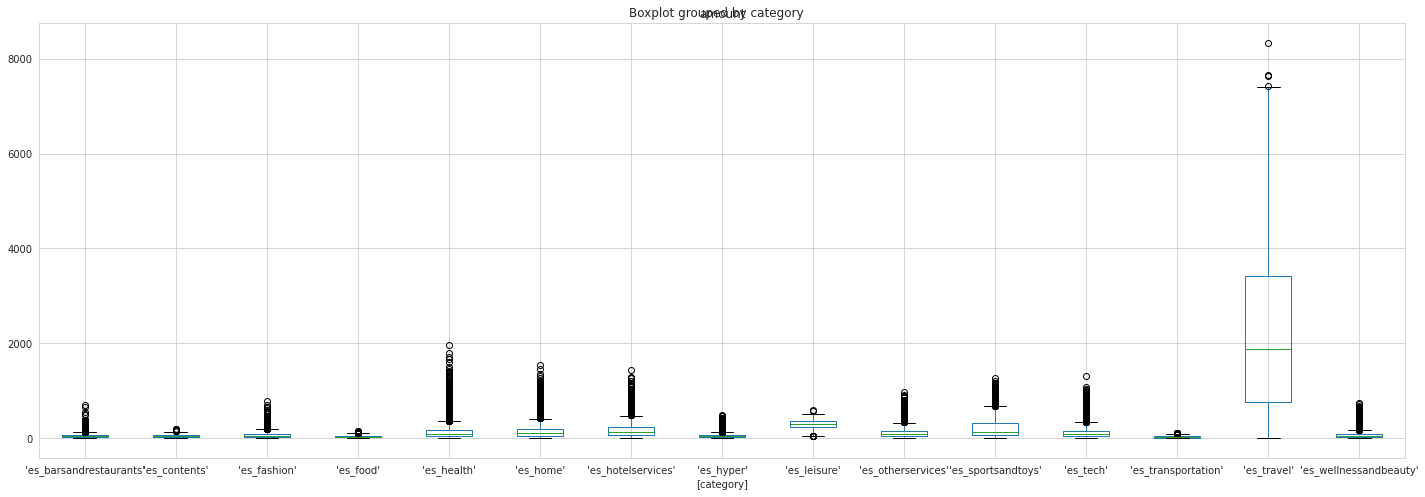

In [11]:
df[['amount', 'category']].boxplot(by = 'category', figsize = (20,7))
plt.tight_layout()

In [12]:
df.groupby('category').mean().sort_values('amount', ascending = False)

,step,amount,fraud
category,,,
'es_travel',85.104396,2250.409190,0.793956
'es_leisure',84.667335,288.911303,0.949900
'es_sportsandtoys',81.332834,215.715280,0.495252
'es_hotelservices',92.966170,205.614249,0.314220
'es_home',89.760322,165.670846,0.152064
'es_otherservices',70.445175,135.881524,0.250000
'es_health',100.636211,135.621367,0.105126
'es_tech',95.034177,120.947937,0.066667
'es_fashion',95.426092,65.666642,0.017973


I see. Leisure and travel are two highest category in amount features. Fraudsters choose the categories which people spend more. And if we see the boxplot, we can see, in the travel category, it can be seen that he has a great variety amount of purchase, it can be one of the reason fraudsters choose this category. He/she will be harder to get caught.

In [13]:
df.groupby('age').mean()['fraud']*100

age
'0'    1.957586
'1'    1.185254
'2'    1.251401
'3'    1.192815
'4'    1.293281
'5'    1.095112
'6'    0.974826
'U'    0.594228
Name: fraud, dtype: float64

That's smart... Fraudsters using fake identity, with <= 18yo, and as I know, we cannot imprison people under the age of 18. So maybe, Fraudsters think, it would be less consequences if they use fake identity, show how young they are. 

# Feature Importances

I'm used Predictive Power Score to do feature selection and to see feature importances.

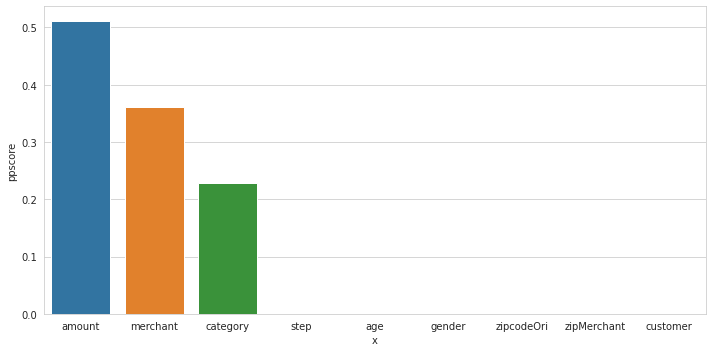

In [14]:
plt.figure(figsize = (10, 5))
df_predictors = pps.predictors(df, y="fraud")
sns.barplot(data=df_predictors, x="x", y="ppscore")
plt.tight_layout()

# Dataset Splitting

In [15]:
X = df.drop(columns= 'fraud')
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((475714, 9), (118929, 9), (475714,), (118929,))

# Preprocessing

In [16]:
numerical = Pipeline([
    ('scaler', StandardScaler())
])

categorical = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer([
    ('numerical', numerical, ['amount']),
    ('categorical', categorical, ['category', 'merchant', 'age', 'zipMerchant'])
])

# Modeling

I'll perform SMOTE. And my objective is, I want to have a model with high Average Precision Score.

## RandomizedSearchCV

### Logistic Regresion

In [17]:
logreg_params = {
    'algo__fit_intercept': [True, False],
    'algo__C': Real(low=-2, high=2, prior='log-uniform')
}

### SMOTE

In [18]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('sm', SMOTE(sampling_strategy = 0.8)),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=101))
])

logreg = RandomizedSearchCV(pipeline, logreg_params, cv= 3, scoring= 'average_precision', random_state=101)
logreg.fit(X_train, y_train)

print(logreg.best_params_)
print(logreg.score(X_train, y_train), logreg.best_score_, logreg.score(X_test, y_test))

{'algo__C': 1.3691263238256033, 'algo__fit_intercept': True}
0.8759206521802209 0.8754256285729967 0.862514901182484


In [19]:
y_pred = logreg.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    117489
           1       0.30      0.98      0.45      1440

    accuracy                           0.97    118929
   macro avg       0.65      0.97      0.72    118929
weighted avg       0.99      0.97      0.98    118929



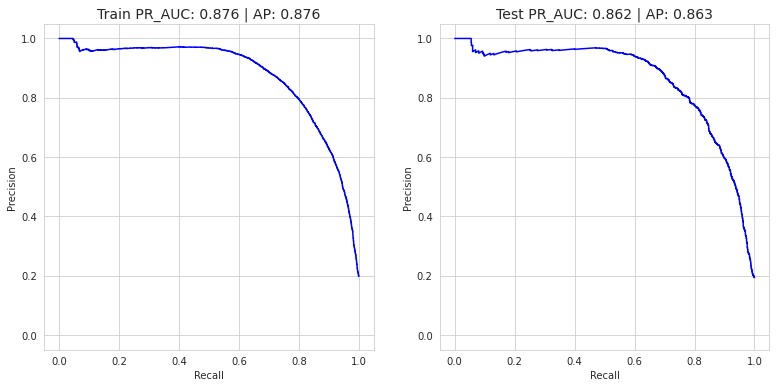

In [53]:
plot_pr_curve(X_train, y_train, X_test, y_test, logreg)

## Manual Tuning

Unfortunately, I'm not used RandomizedSearchCV for another model except Logistic Regression. The reason is: This is a huge dataset (+ SMOTE) so using RandomizedSearchCV it cost many of time. And I'm not sure my laptop can handle it. So I decided to tuning my model by manually.

### Random Forest

In [51]:
rf = Pipeline([
    ('prep', preprocessor),
    ('sm', SMOTE(sampling_strategy = 0.8)),
    ('algo', RandomForestClassifier(n_estimators=150,max_depth=7,random_state=101))
])

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)
print(classification_report(y_test, y_pred))
print('Random Forest Classifier => AP score: {}'.format(average_precision_score(y_test, y_pred_proba[:,1])))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    117489
           1       0.18      0.99      0.30      1440

    accuracy                           0.94    118929
   macro avg       0.59      0.97      0.63    118929
weighted avg       0.99      0.94      0.96    118929

Random Forest Classifier => AP score: 0.7607888216219187


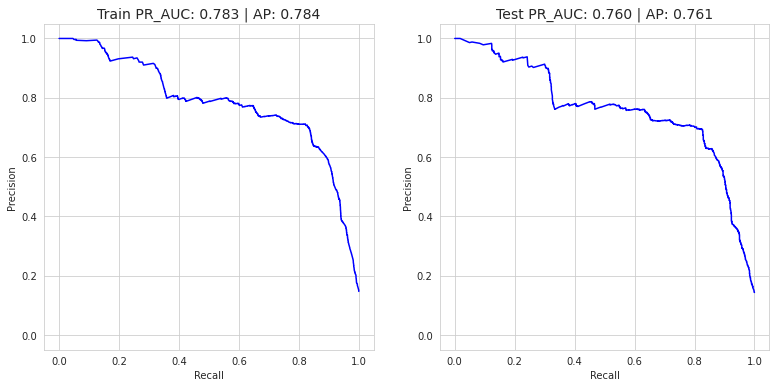

In [52]:
plot_pr_curve(X_train, y_train, X_test, y_test, rf)

### XGBoost

In [47]:
xgb = Pipeline([
    ('prep', preprocessor),
    ('sm', SMOTE(sampling_strategy = 0.8)),
    ('algo', XGBClassifier(max_depth=7, learning_rate=0.08, n_estimators=300,
                          gamma = 1, subsample= 0.5, colsample_bytree=1, random_state = 101))
])

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)
print(classification_report(y_test, y_pred))
print('XGBoost Classifier => AP score: {}'.format(average_precision_score(y_test, y_pred_proba[:,1])))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    117489
           1       0.35      0.96      0.51      1440

    accuracy                           0.98    118929
   macro avg       0.67      0.97      0.75    118929
weighted avg       0.99      0.98      0.98    118929

XGBoost Classifier => AP score: 0.8957515556626793


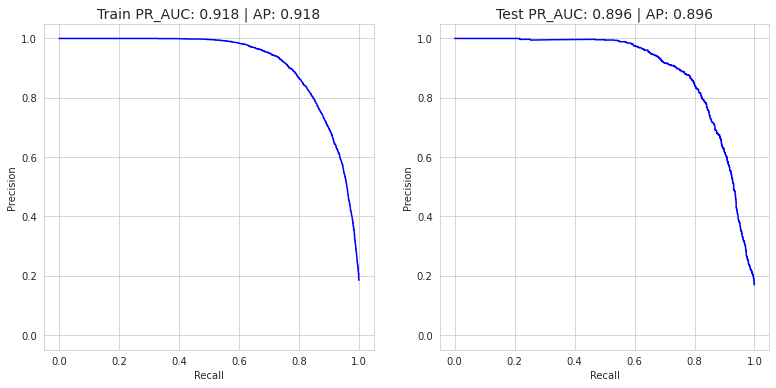

In [50]:
plot_pr_curve(X_train, y_train, X_test, y_test, xgb)

# Conclusion

Based on AP (Average Precision) Score, we can say, XGBoost Classifier is the best model between Logistic Regression and Random Forest Classifier. 